# Predicting node criticality for internet network topologies

This project uses classic network models such as the Bara Albert, and Holmes Kim models to investigate if these models can replicate the effect of node failures on real internet network topologies provided from [sk2/topologyzoo](https://github.com/sk2/topologyzoo/tree/master/sources). More information in this dataset can also be found [here](https://topology-zoo.org/dataset.html).

## 1. Setup 

1. Downloading utility functions

In [45]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

2. Importing libraries

In [70]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import os
import csv
import random
from empiricaldist import Pmf

from utils import decorate, savefig
from graph_visualisation import color_critical_nodes, model_plotter, cdf_plotter, hist_plotter

3. Setting constants

In [52]:
NOTEBOOK_NAME = "Node Criticality Simulation.ipynb"
RANDOM_SEED = 4403
random.seed(RANDOM_SEED)

DATASET_FILE_EXT = ".graphml"
DATASET_PATH = os.path.join(os.path.dirname(NOTEBOOK_NAME),'..' ,'data')
FIGURES_MODEL_PATH = os.path.join(os.path.dirname(NOTEBOOK_NAME), '..', 'figures', 'models')
FIGURES_VISUAL_PATH = os.path.join(os.path.dirname(NOTEBOOK_NAME), '..', 'figures', 'data visualisation')
RESULTS_PATH = os.path.join(os.path.dirname(NOTEBOOK_NAME),'..' ,'results')

REAL_CSV_PATH = os.path.join(RESULTS_PATH, 'real.csv')
BA_CSV_PATH = os.path.join(RESULTS_PATH, 'ba.csv')
HK_CSV_PATH = os.path.join(RESULTS_PATH, 'hk.csv')

4. Set up of directories to store results

In [53]:
# for figures of models and the visualisation graphs
os.makedirs(FIGURES_MODEL_PATH, exist_ok=True)
os.makedirs(FIGURES_VISUAL_PATH, exist_ok=True)
# for results.csv
os.makedirs(RESULTS_PATH, exist_ok=True)

## 2. Heuristics

**Critical Fraction**: Calculate the critical fraction for a graph with targeted or random failures

In [27]:
def critical_fraction (graph: nx.Graph, randomFailure=True, threshold=0.5) -> tuple:
	"""
	Returns the critical fraction of nodes (the smallest number) that can be removed before,
	The largest connected component in the graph is proportionally lesser to the original graph by the threshold.
	@param: a networkx graph object
	@param: random: whether the code performs a randomised node failure or targeted node attack.
	@param: an optional threshold for the critical fraction threshold
	@return: A tuple of the (fraction of nodes, list of removed nodes) or None (which should not be possible)
	"""
	# 1. Get the nodes in the graph
	nodes = list (graph.nodes)
	total_nodes = len (nodes)

	# 2. Order nodes in terms of degree - this ensures that the smallest number of nodes are selected
	# https://stackoverflow.com/a/48382895
	if randomFailure is True:
		nodes_by_degree = list(graph.degree())
		# set the random seed
		random.seed (RANDOM_SEED)
		random.shuffle(nodes_by_degree)
	else:
		nodes_by_degree = sorted(graph.degree, key=lambda x: x[1], reverse=True)

	# 3. Track the removed nodes, and copy the original graph to remove nodes from it
	removed_nodes = []
	graph_remove = graph.copy()

	# 4. Remove each node
	for node_entry in nodes_by_degree:
		node = node_entry[0]
		graph_remove.remove_node(node)
		removed_nodes.append(node)

		# 5. Calculate the critical fraction and return
		if len(graph_remove) > 0:
			# get size of GCC : https://stackoverflow.com/a/62838497
			GCCs = sorted(nx.connected_components(graph_remove), key=len, reverse=True)
			giantCC = graph_remove.subgraph(GCCs[0])
			CF = len (giantCC) / total_nodes
			if (CF < threshold):
				node_frac = len (removed_nodes) / total_nodes
				return (node_frac, removed_nodes)
		else:
			return (1.0, removed_nodes) # 1 indicates full disconnection

**Average shortest path length**: Calculate the average shortest path length between the nodes in a graph for the largest connected component

In [28]:
def safeASPL(graph):
	if nx.number_connected_components(graph) > 1:
		gcc = max(nx.connected_components(graph), key=len)
		subgraph = graph.subgraph(gcc).copy()
		return nx.average_shortest_path_length(subgraph)
	else:
		return nx.average_shortest_path_length(graph)

## 3. Model Simulations

TODO: Add introduction

### Step 1: Simulate the models and write results to the csv for each of the graphs and each of the heuristics

TODO: add more detail

In [32]:
with open(REAL_CSV_PATH, 'w', newline='') as real, \
	open(BA_CSV_PATH, 'w', newline='') as ba, \
	open(HK_CSV_PATH, 'w', newline='') as hk:

	writer1 = csv.writer(real)
	writer2 = csv.writer(ba)
	writer3 = csv.writer(hk)

	for file_path, writer in zip([REAL_CSV_PATH, BA_CSV_PATH, HK_CSV_PATH], [writer1, writer2, writer3]):
		if os.stat(file_path).st_size == 0:
			writer.writerow([
				"Graph",
				"Random Critical Fraction",
				"Targeted Critical Fraction",
				"Average Shortest Path Length",
				"Average Clustering Coefficient",
				"No. Connected Components"
			])

	# filter files by extension first
	allFileNames = os.listdir(DATASET_PATH)
	dataFileNames = [file for file in allFileNames if file.endswith(DATASET_FILE_EXT)]
	totalFiles = len (dataFileNames)
	currentFile = 1

	for filename in dataFileNames:
		dataTitle = filename[:-len(DATASET_FILE_EXT)]

		### real data
		realData = nx.read_graphml(os.path.join(DATASET_PATH, filename))
		num_nodes = realData.number_of_nodes()
		num_edges = realData.number_of_edges()
		realDegrees = dict(realData.degree())
		realDegList = list(realDegrees.values())
		realACC = nx.average_clustering(nx.Graph(realData))

		m = max(1, min(num_nodes - 1, int(round(num_edges / num_nodes))))

		### BA Graph with same number of nodes as real data, and roughly the same degree as the real data (not exact)
		baraAlbert = nx.barabasi_albert_graph(num_nodes, m, seed=RANDOM_SEED)
		bADegrees = dict(baraAlbert.degree())
		bADegList = list(bADegrees.values())
		bAACC = nx.average_clustering(nx.Graph(baraAlbert))

		### HK Graph, Same Parameters as BA
		holmesKim = nx.powerlaw_cluster_graph(num_nodes, m, realACC, seed=RANDOM_SEED)
		hKDegrees = dict(holmesKim.degree())
		hKDegList = list(hKDegrees.values())
		hkACC = nx.average_clustering(nx.Graph(holmesKim))

		### create PMFs for these
		pmf_real = Pmf.from_seq(realDegList)
		pmf_ba = Pmf.from_seq(bADegList)
		pmf_hk = Pmf.from_seq(hKDegList)

		# Get critical fraction
		realRCF, realRandNodeRemoved = critical_fraction(realData)
		realTCF, realTargetNodeRemoved = critical_fraction(realData, False)

		bARCF, bARandNodeRemoved = critical_fraction(baraAlbert)
		bATCF, bATargetNodeRemoved = critical_fraction(baraAlbert, False)

		hkRCF, hkRandNodeRemoved = critical_fraction(holmesKim)
		hkTCF, hkTargetNodeRemoved = critical_fraction(holmesKim, False)

		plt.figure(figsize=(19.2, 10.8))
		options = dict(ls='', marker='.')

		model_plotter(231, realData, f"Real {dataTitle}", "blue", realTargetNodeRemoved)
		model_plotter(232, baraAlbert, f"BA {dataTitle}", "purple", bATargetNodeRemoved)
		model_plotter(233, holmesKim, f"HK {dataTitle}", "green", hkTargetNodeRemoved)

		model_plotter(234, pmf_real, f"PMF Real {dataTitle}", "blue", probMF=True)
		model_plotter(235, pmf_ba, f"PMF BA {dataTitle}", "purple", probMF=True)
		model_plotter(236, pmf_hk, f"PMF HK {dataTitle}", "green", probMF=True)

		plt.savefig(f"{os.path.join(FIGURES_MODEL_PATH, dataTitle)}.png")
		plt.close()

		writer1.writerow([
			dataTitle,
			realRCF,
			realTCF,
			safeASPL(realData),
			realACC,
			nx.number_connected_components(realData)
		])

		writer2.writerow([
			f"BA {dataTitle}",
			bARCF,
			bATCF,
			safeASPL(baraAlbert),
			bAACC,
			nx.number_connected_components(baraAlbert)
		])

		writer3.writerow([
			f"HK {dataTitle}",
			hkRCF,
			hkTCF,
			safeASPL(holmesKim),
			hkACC,
			nx.number_connected_components(holmesKim)
		])

		# logging
		print(f"{currentFile} / {totalFiles} for {dataTitle}")
		currentFile += 1


1 / 261 for Nordu1997
2 / 261 for Netrail
3 / 261 for Abilene
4 / 261 for Belnet2010
5 / 261 for Harnet
6 / 261 for Belnet2005
7 / 261 for IowaStatewideFiberMap
8 / 261 for Evolink
9 / 261 for BtAsiaPac
10 / 261 for Forthnet
11 / 261 for Cesnet1999
12 / 261 for Reuna
13 / 261 for Cesnet1993
14 / 261 for PionierL1
15 / 261 for Garr200912
16 / 261 for Geant2001
17 / 261 for Mren
18 / 261 for Peer1
19 / 261 for Cudi
20 / 261 for VisionNet
21 / 261 for Grena
22 / 261 for Uninet
23 / 261 for Xeex
24 / 261 for Uninett2011
25 / 261 for Funet
26 / 261 for HiberniaIreland
27 / 261 for BtLatinAmerica
28 / 261 for Geant2009
29 / 261 for Nordu2010
30 / 261 for Psinet
31 / 261 for Roedunet
32 / 261 for Gambia
33 / 261 for Navigata
34 / 261 for KentmanJan2011
35 / 261 for Garr201008
36 / 261 for Jgn2Plus
37 / 261 for Renater2008
38 / 261 for Garr201102
39 / 261 for Marwan
40 / 261 for Quest
41 / 261 for Dataxchange
42 / 261 for Sanren
43 / 261 for Garr200909
44 / 261 for AsnetAm
45 / 261 for Xspediu

Once the simulation is complete we can view some of the results.

1. For example, for the **Nordu1997** network topology - the modelling results with the PMF, with highlighting critical nodes

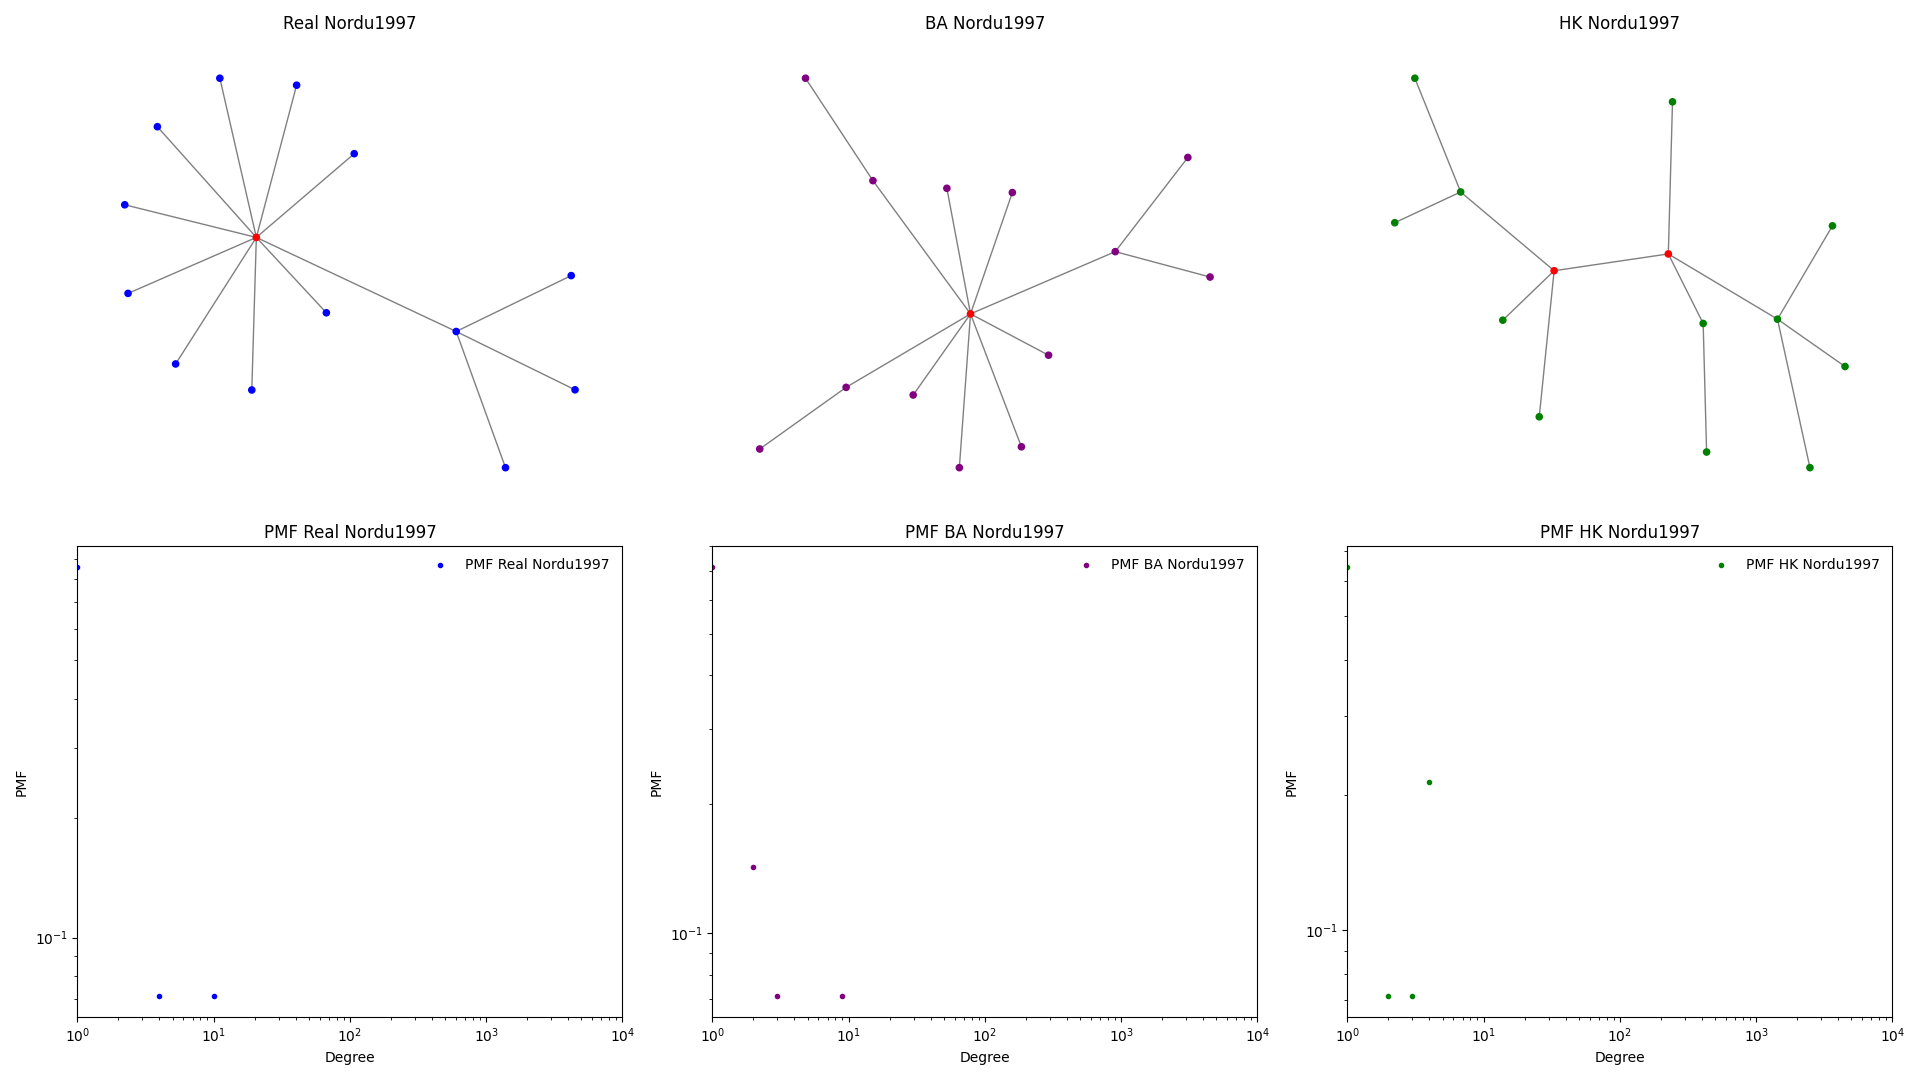

In [94]:
from IPython.display import Image, display
img_path = f"{os.path.join(FIGURES_MODEL_PATH, "Nordu1997")}.png"
display(Image(filename=img_path))

2. Results of numerical heuristics for the Real , Bara Albert, and Holmes Kim models that are saved in respective CSVs.

In [95]:
import pandas as pd

In [35]:
pd.read_csv(REAL_CSV_PATH).head()

,Graph,Random Critical Fraction,Targeted Critical Fraction,Average Shortest Path Length,Average Clustering Coefficient,No. Connected Components
0,Nordu1997,0.214286,0.071429,2.153846,0.000000,1
1,Netrail,0.571429,0.285714,1.523810,0.566667,1
2,Abilene,0.363636,0.363636,2.418182,0.151515,1
3,Belnet2010,0.227273,0.090909,3.424242,0.000000,1
4,Harnet,0.190476,0.142857,3.057143,0.000000,1


In [37]:
pd.read_csv(BA_CSV_PATH).head()

,Graph,Random Critical Fraction,Targeted Critical Fraction,Average Shortest Path Length,Average Clustering Coefficient,No. Connected Components
0,BA Nordu1997,0.357143,0.071429,2.318681,0.0,1
1,BA Netrail,0.571429,0.142857,1.714286,0.0,1
2,BA Abilene,0.454545,0.090909,1.963636,0.0,1
3,BA Belnet2010,0.409091,0.045455,3.112554,0.0,1
4,BA Harnet,0.380952,0.047619,3.000000,0.0,1


In [38]:
pd.read_csv(HK_CSV_PATH).head()

,Graph,Random Critical Fraction,Targeted Critical Fraction,Average Shortest Path Length,Average Clustering Coefficient,No. Connected Components
0,HK Nordu1997,0.500000,0.142857,2.879121,0.0,1
1,HK Netrail,0.428571,0.142857,2.190476,0.0,1
2,HK Abilene,0.454545,0.090909,2.690909,0.0,1
3,HK Belnet2010,0.454545,0.090909,3.138528,0.0,1
4,HK Harnet,0.428571,0.095238,3.114286,0.0,1


## Data Visualisation

After the results for the model simulations have been generated, the CSV can be read, and these results can be used to generate visualisations that can evaluate the approximation power of each of the graph types used. 

In [54]:
def csv_reader(csvreader):
	RCF, TCF, ASPL, ACC, CCs = [], [], [], [], []
	next(csvreader)
	for row in csvreader:
		RCF.append(float(row[1]))
		TCF.append(float(row[2]))
		ASPL.append(float(row[3]))
		ACC.append(float(row[4]))
		CCs.append(float(row[5]))
	return RCF, TCF, ASPL, ACC, CCs

**Generating the graphs**: TODO add more description

In [83]:
with open(REAL_CSV_PATH, 'r', newline='') as real, \
	open(BA_CSV_PATH, 'r', newline='') as ba, \
	open(HK_CSV_PATH, 'r', newline='') as hk:

	reader1 = csv.reader(real, delimiter=',')
	reader2 = csv.reader(ba, delimiter=',')
	reader3 = csv.reader(hk, delimiter=',')

	realRCF, realTCF, realASPL, realACC, realCCs = csv_reader(reader1)
	bARCF, bATCF, bAASPL, bAACC, bACCs = csv_reader(reader2)
	hkRCF, hkTCF, hkASPL, hkACC, hkCCs = csv_reader(reader3)



	### RCF
	cdf_plotter(realRCF, bARCF, hkRCF,
		    "CDF - Random Critical Fraction",
		    "Critical Fraction",
		    "Cumulative Probability")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Random Critical Fraction")}.png")

	hist_plotter(realRCF, bARCF, hkRCF,
		     "Histogram - Random Critical Fraction",
		     "Critical Fraction",
		     "Probability Density")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Random Critical Fraction")}.png")

	### TCF
	cdf_plotter(realTCF, bATCF, hkTCF,
		    "CDF - Targeted Critical Fraction",
		    "Critical Fraction",
		    "Cumulative Probability")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Targeted Critical Fraction")}.png")

	hist_plotter(realTCF, bATCF, hkTCF,
		     "Histogram - Targeted Critical Fraction",
		     "Critical Fraction",
		     "Probability Density")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Targeted Critical Fraction")}.png")

	### ASPL
	cdf_plotter(realASPL, bAASPL, hkASPL,
		    "CDF - Average Shortest Path Length",
		    "Average Shortest Path Length",
		    "Cumulative Probability")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Average Shortest Path Length")}.png")

	hist_plotter(realASPL, bAASPL, hkASPL,
		     "Histogram - Average Shortest Path Length",
		     "Shortest Path Length",
		     "Probability Density")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Average Shortest Path Length")}.png")

	### ACC
	cdf_plotter(realACC, bAACC, hkACC,
		    "CDF - Average Clustering Coefficient",
		    "Average Clustering Coefficient",
		    "Cumulative Probability")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Average Clustering Coefficient")}.png")

	hist_plotter(realACC, bAACC, bAACC,
		     "Histogram - Average Clustering Coefficient",
		     "Average Clustering Coefficient",
		     "Probability Density")
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Average Clustering Coefficient")}.png")


	### Heatmap
	data = pd.DataFrame({
		"Network": ["Real", "BA", "HK"],
		"RCF": [np.mean(realRCF), np.mean(bARCF), np.mean(hkRCF)],
		"TCF": [np.mean(realTCF), np.mean(bATCF), np.mean(hkTCF)],
		"ASPL": [np.mean(realASPL), np.mean(bAASPL), np.mean(hkASPL)],
		"ACC": [np.mean(realACC), np.mean(bAACC), np.mean(hkACC)],
		"CCs": [np.mean(realCCs), np.mean(bACCs), np.mean(hkCCs)]
	})

	data.set_index("Network", inplace=True)

	plt.figure(figsize=(9,5))
	sns.heatmap(data, annot=True, cmap="coolwarm", fmt=".2f")
	plt.title("Network Metrics Comparison")
	plt.savefig(f"{os.path.join(FIGURES_VISUAL_PATH, "Network Metrics Comparison")}.png")
	plt.close()
	print(f"{os.path.join(FIGURES_VISUAL_PATH, "Network Metrics Comparison")}.png")

../figures/data visualisation/CDF - Random Critical Fraction.png
../figures/data visualisation/Histogram - Random Critical Fraction.png
../figures/data visualisation/CDF - Targeted Critical Fraction.png
../figures/data visualisation/Histogram - Targeted Critical Fraction.png
../figures/data visualisation/CDF - Average Shortest Path Length.png
../figures/data visualisation/Histogram - Average Shortest Path Length.png
../figures/data visualisation/CDF - Average Clustering Coefficient.png
../figures/data visualisation/Histogram - Average Clustering Coefficient.png
../figures/data visualisation/Network Metrics Comparison.png


Now, we can view each of the graphs

In [84]:
from IPython.display import Image, display

1. CDF - Random Critical Fraction

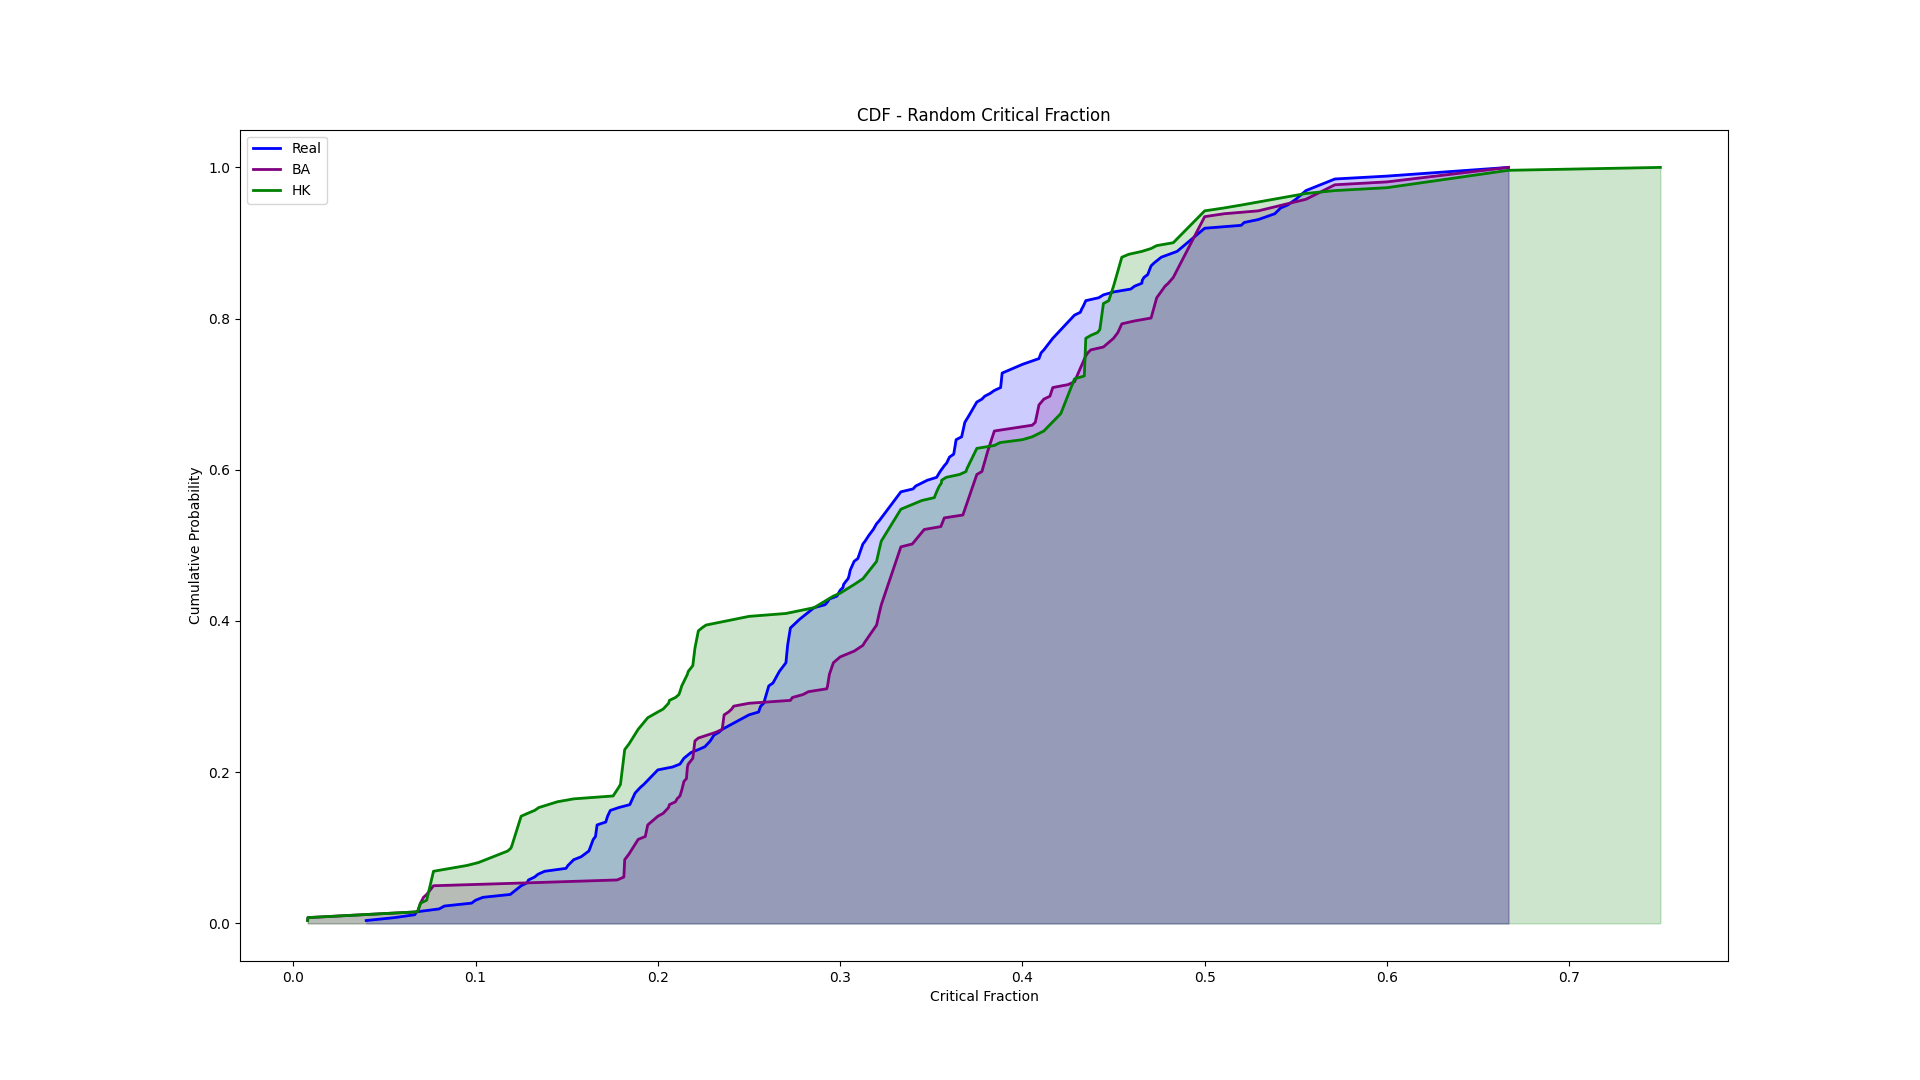

In [85]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Random Critical Fraction")}.png"
display(Image(filename=img_path))

2. Histogram - Random Critical Fraction

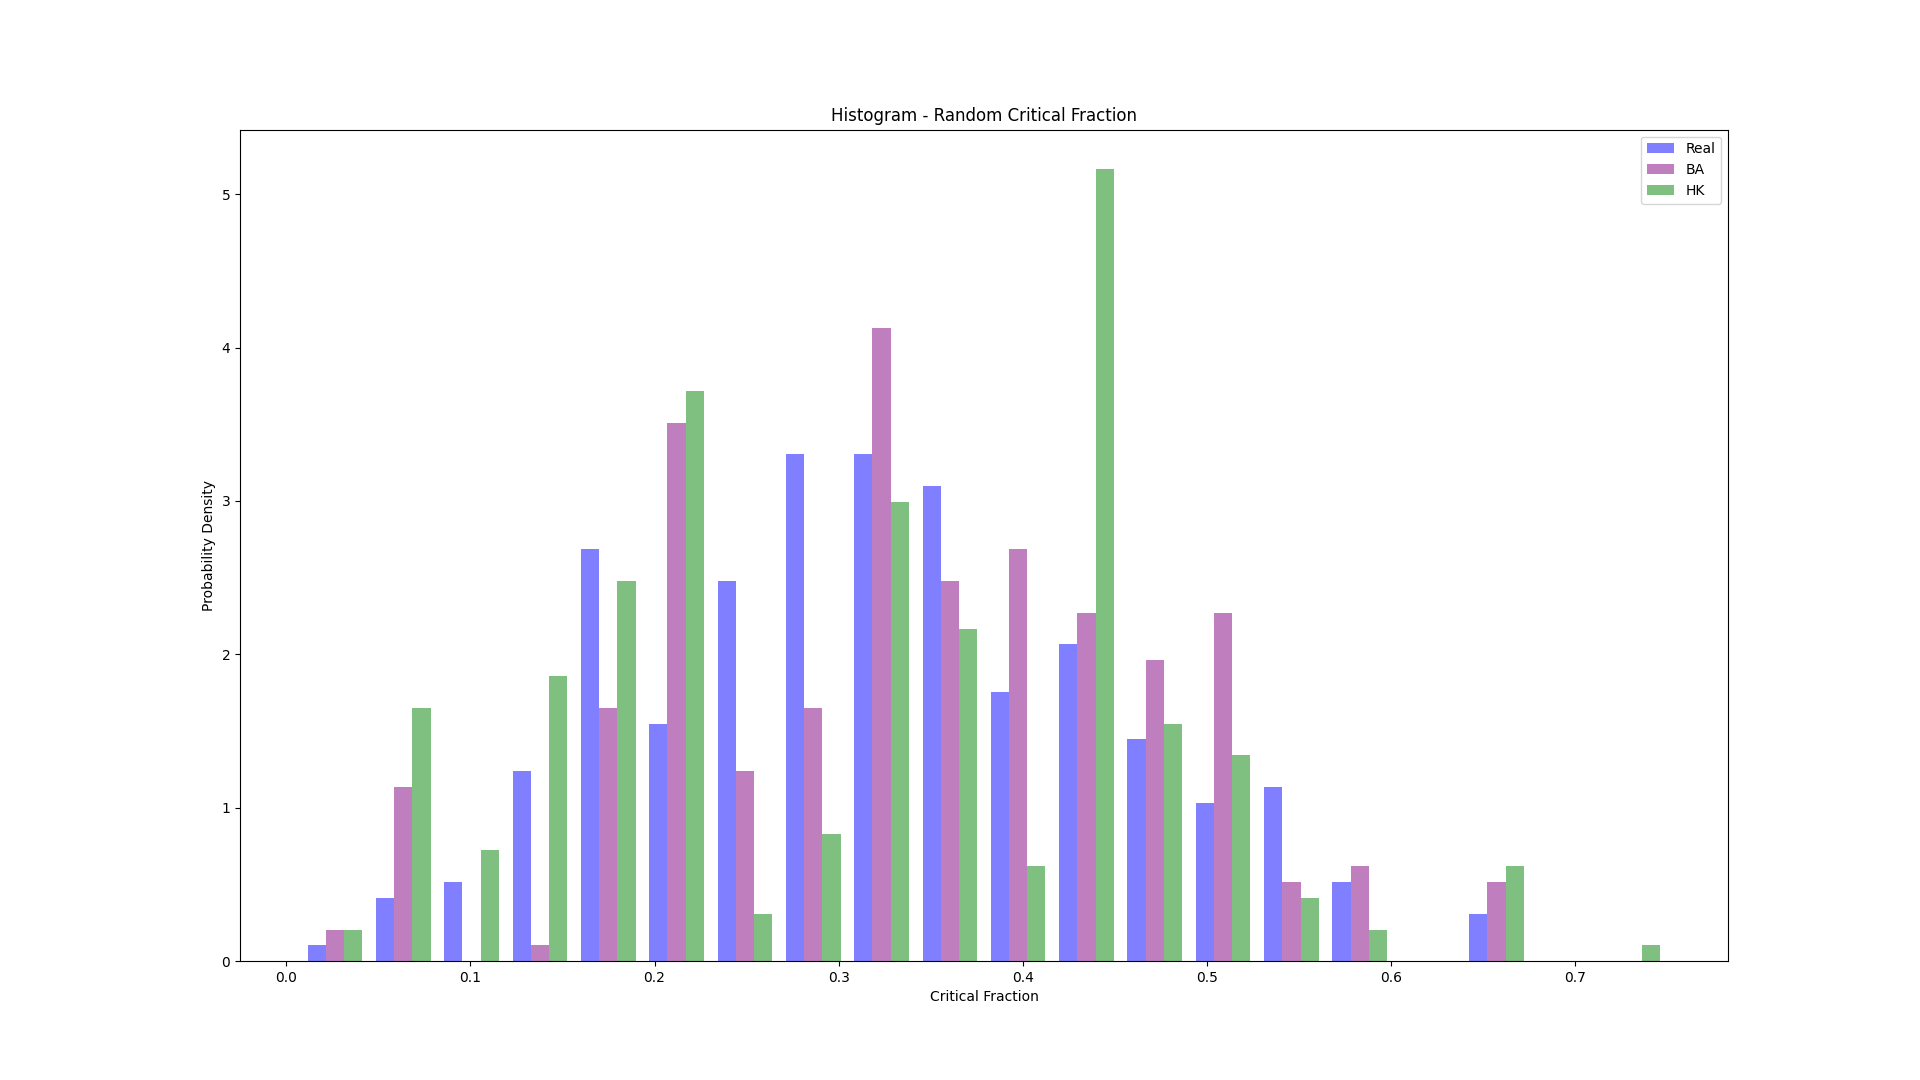

In [86]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Random Critical Fraction")}.png"
display(Image(filename=img_path))

3. CDF - Targeted Critical Fraction

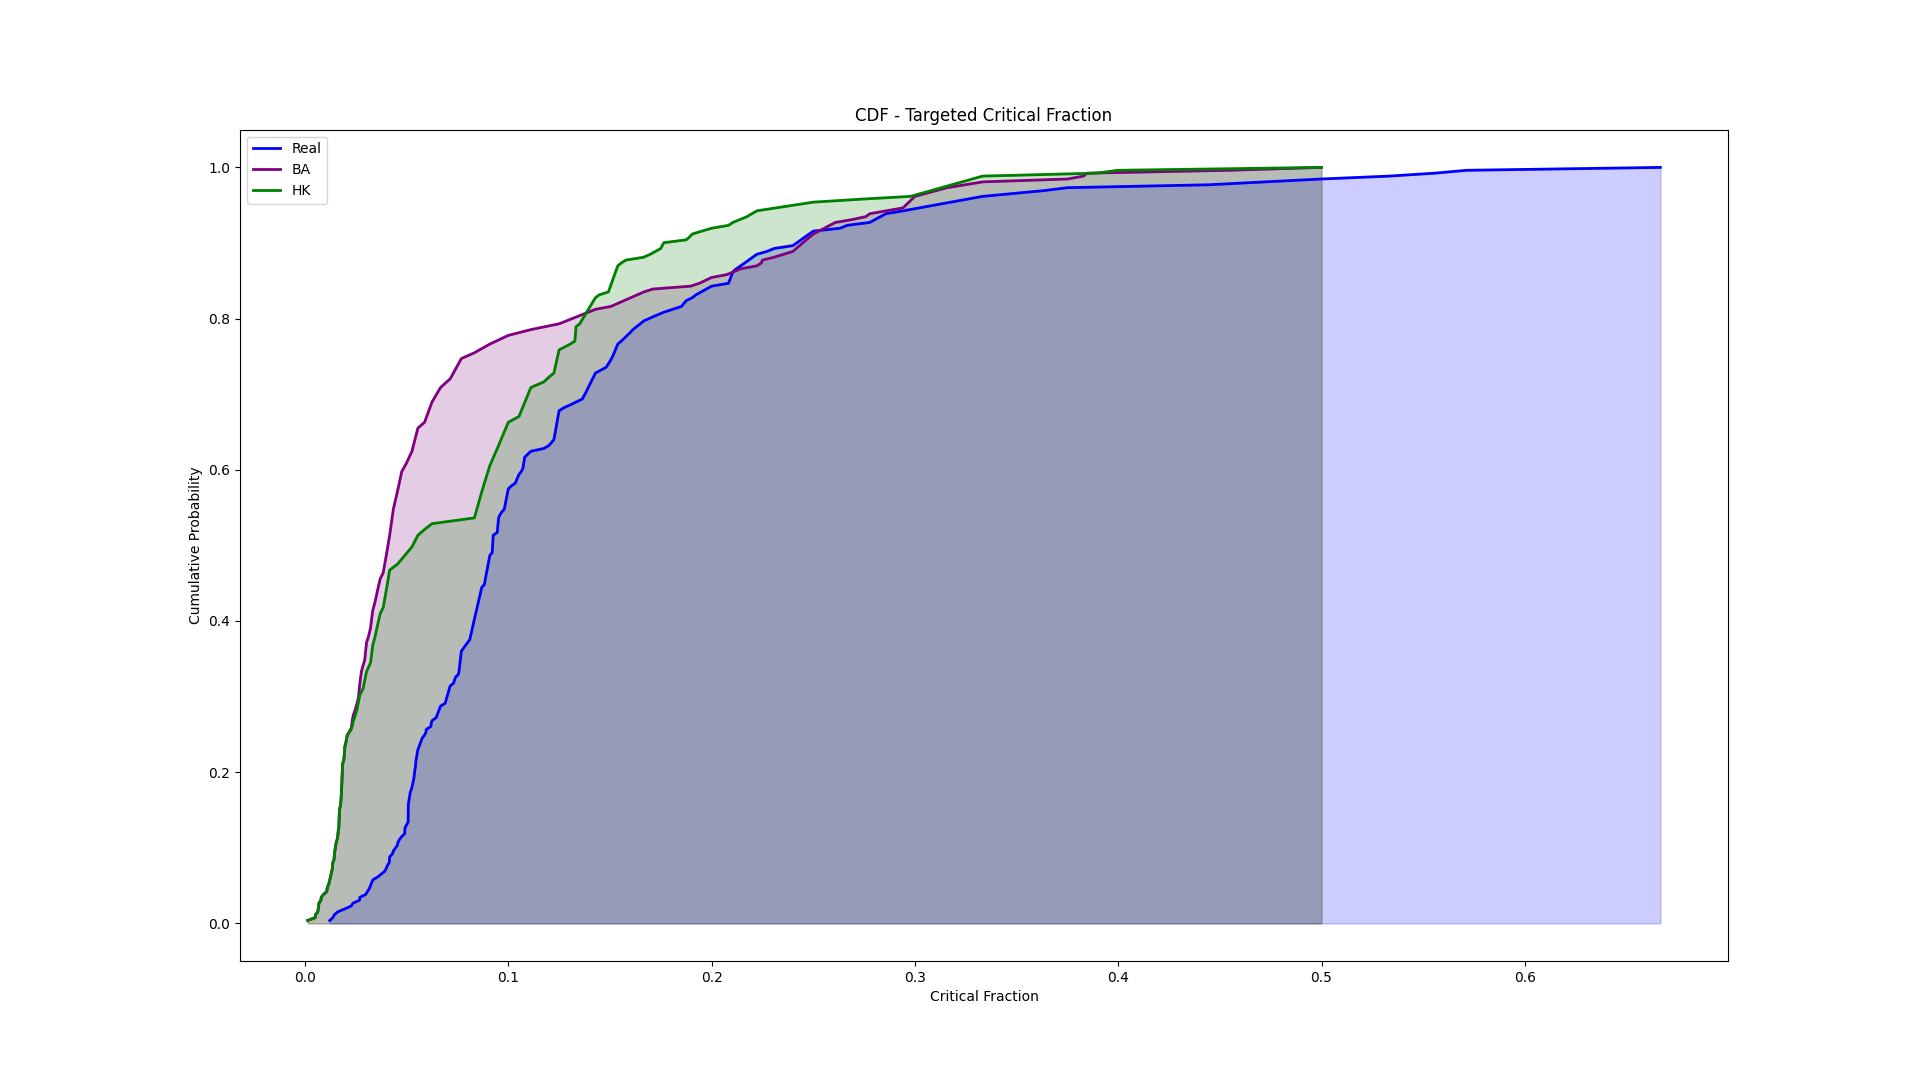

In [87]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Targeted Critical Fraction")}.png"
display(Image(filename=img_path))

4. Histogram - Targeted Critical Fraction

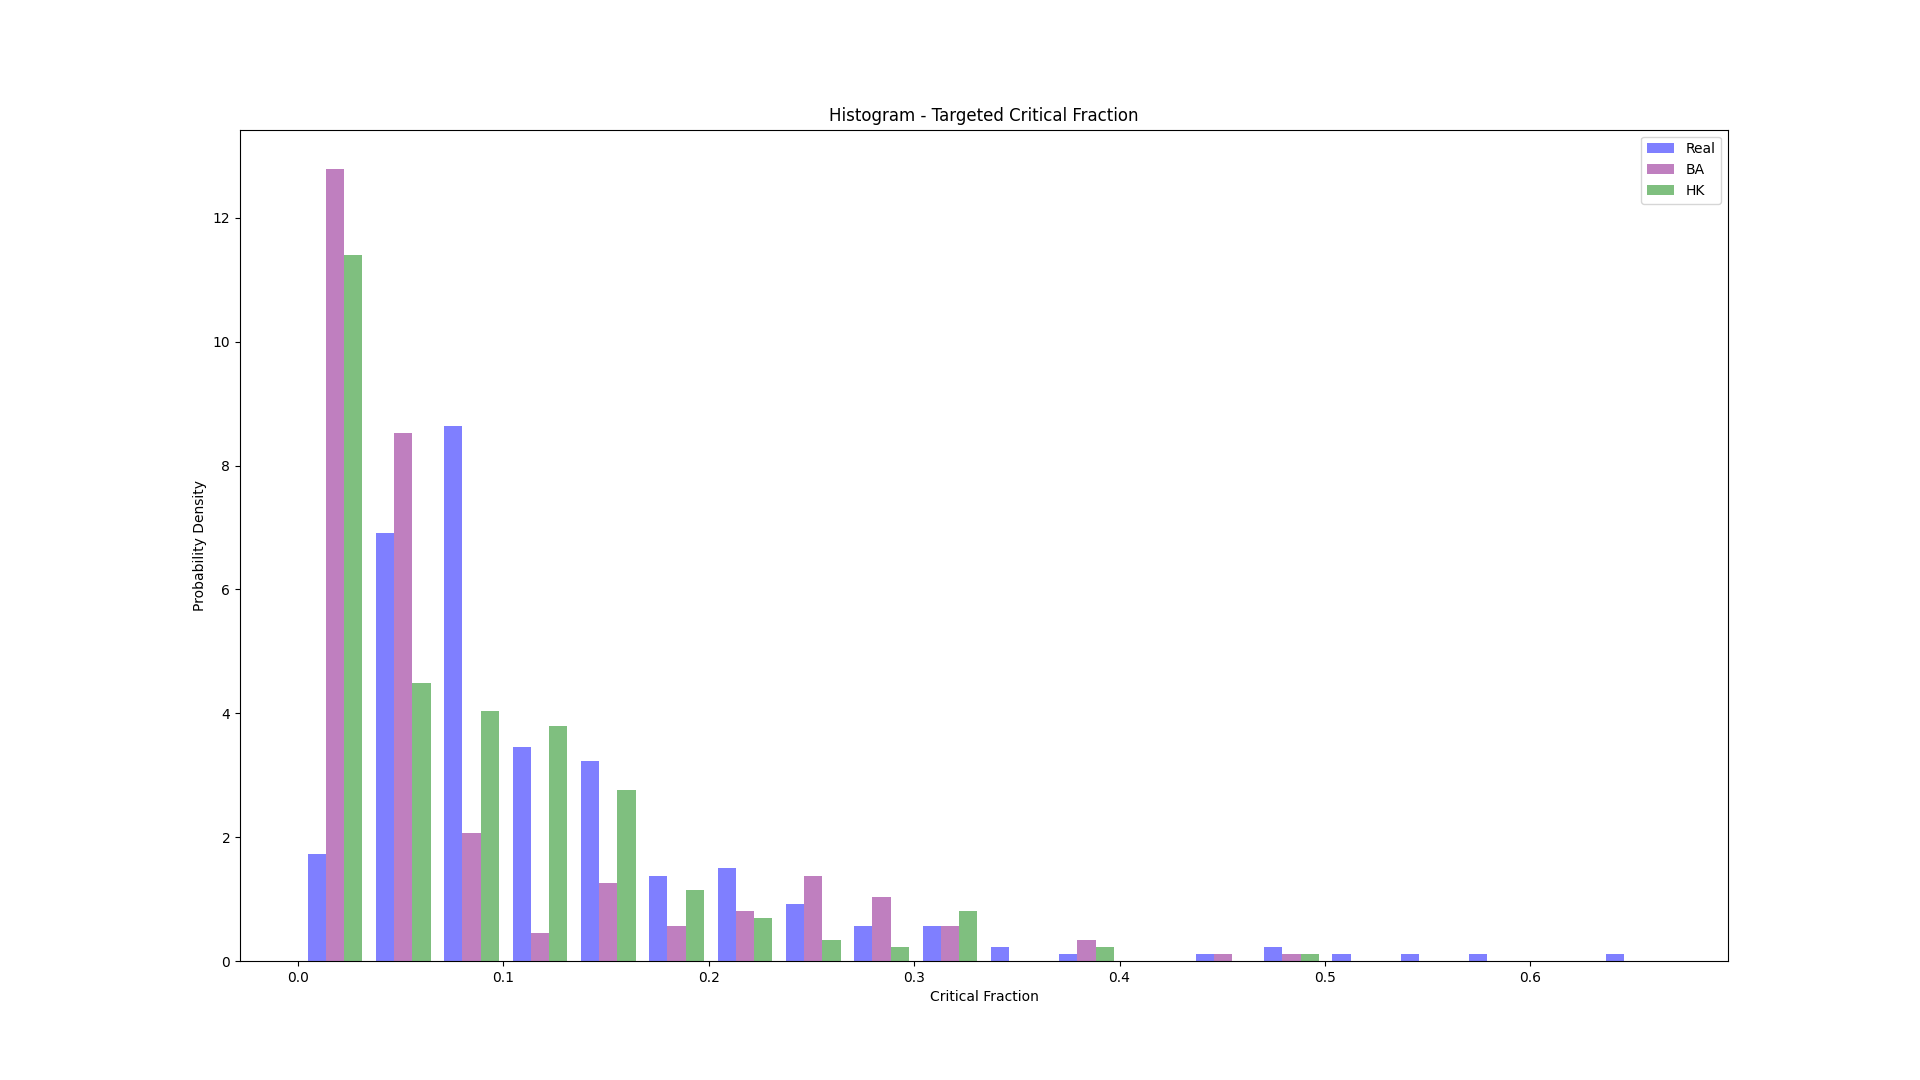

In [88]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Targeted Critical Fraction")}.png"
display(Image(filename=img_path))

5. CDF - Average Shortest Path Length

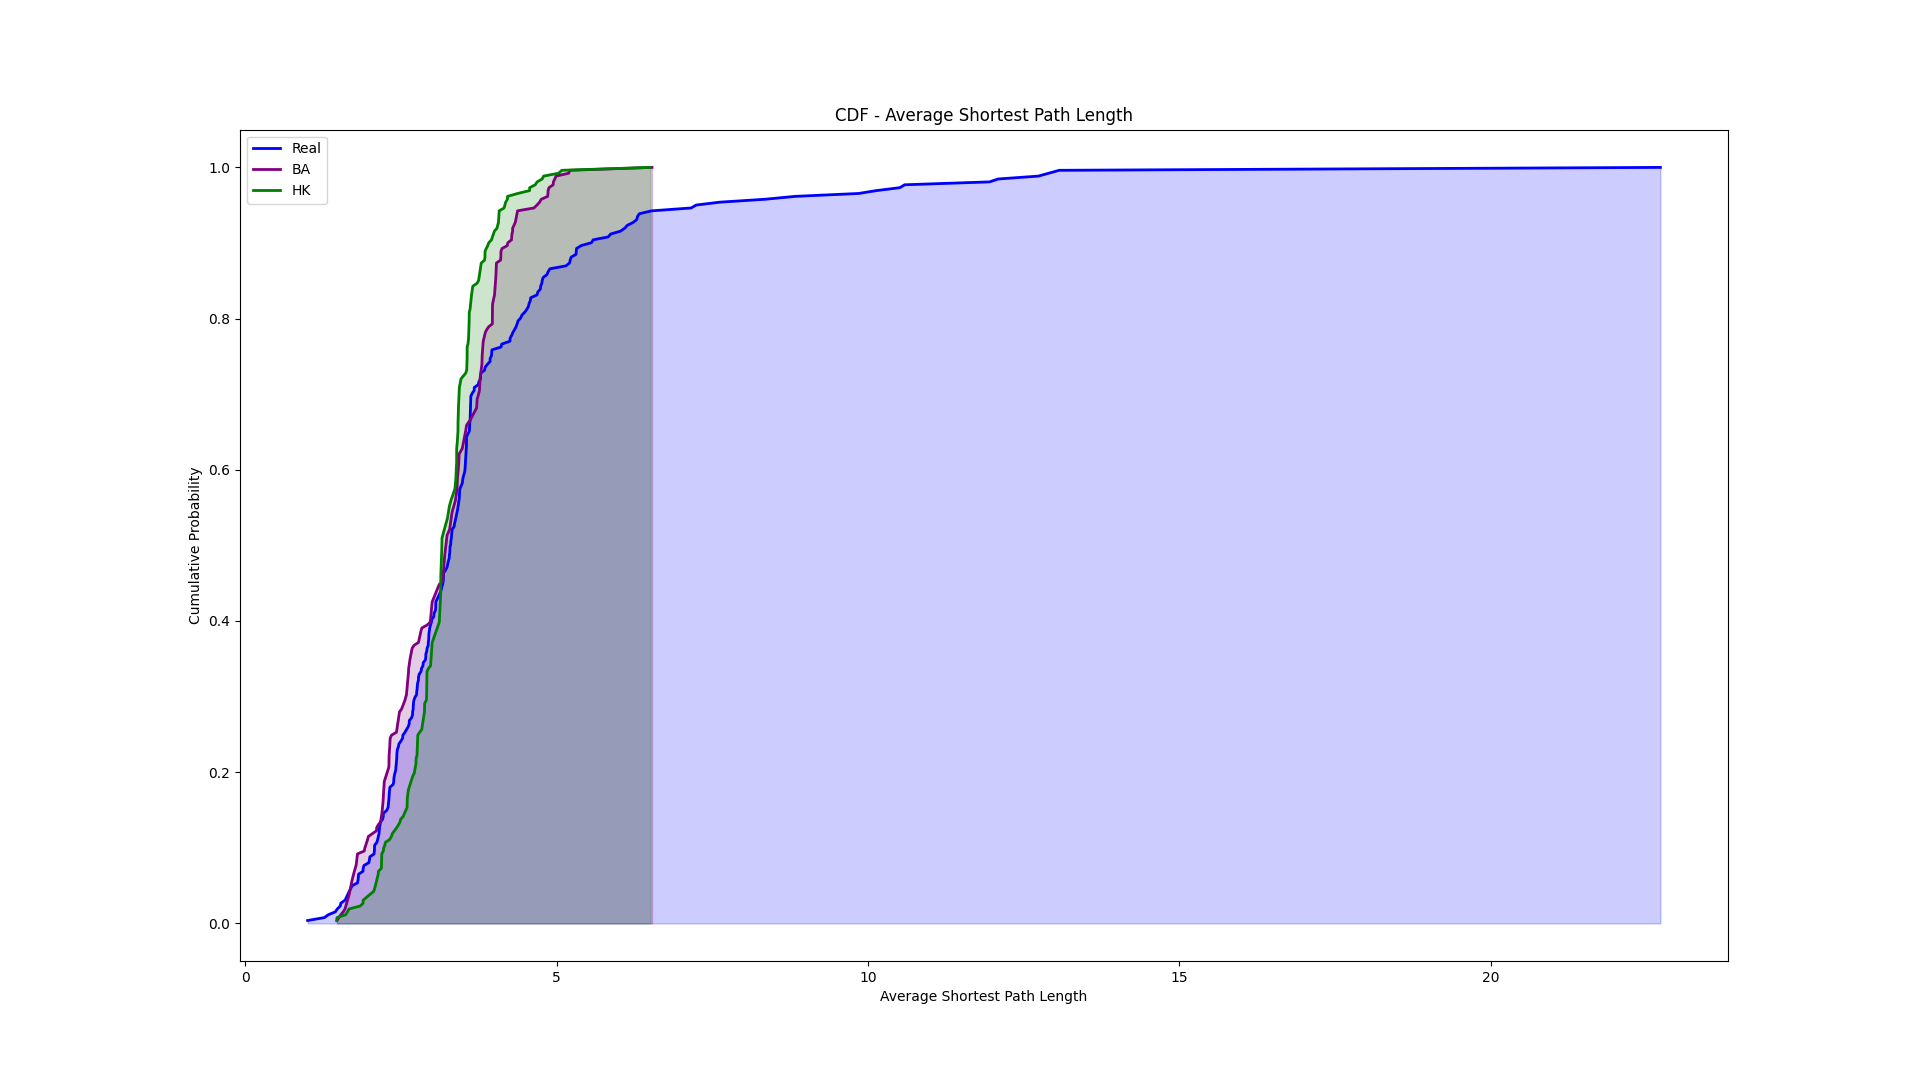

In [89]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Average Shortest Path Length")}.png"
display(Image(filename=img_path))

6. Histogram - Average Shortest Path Length

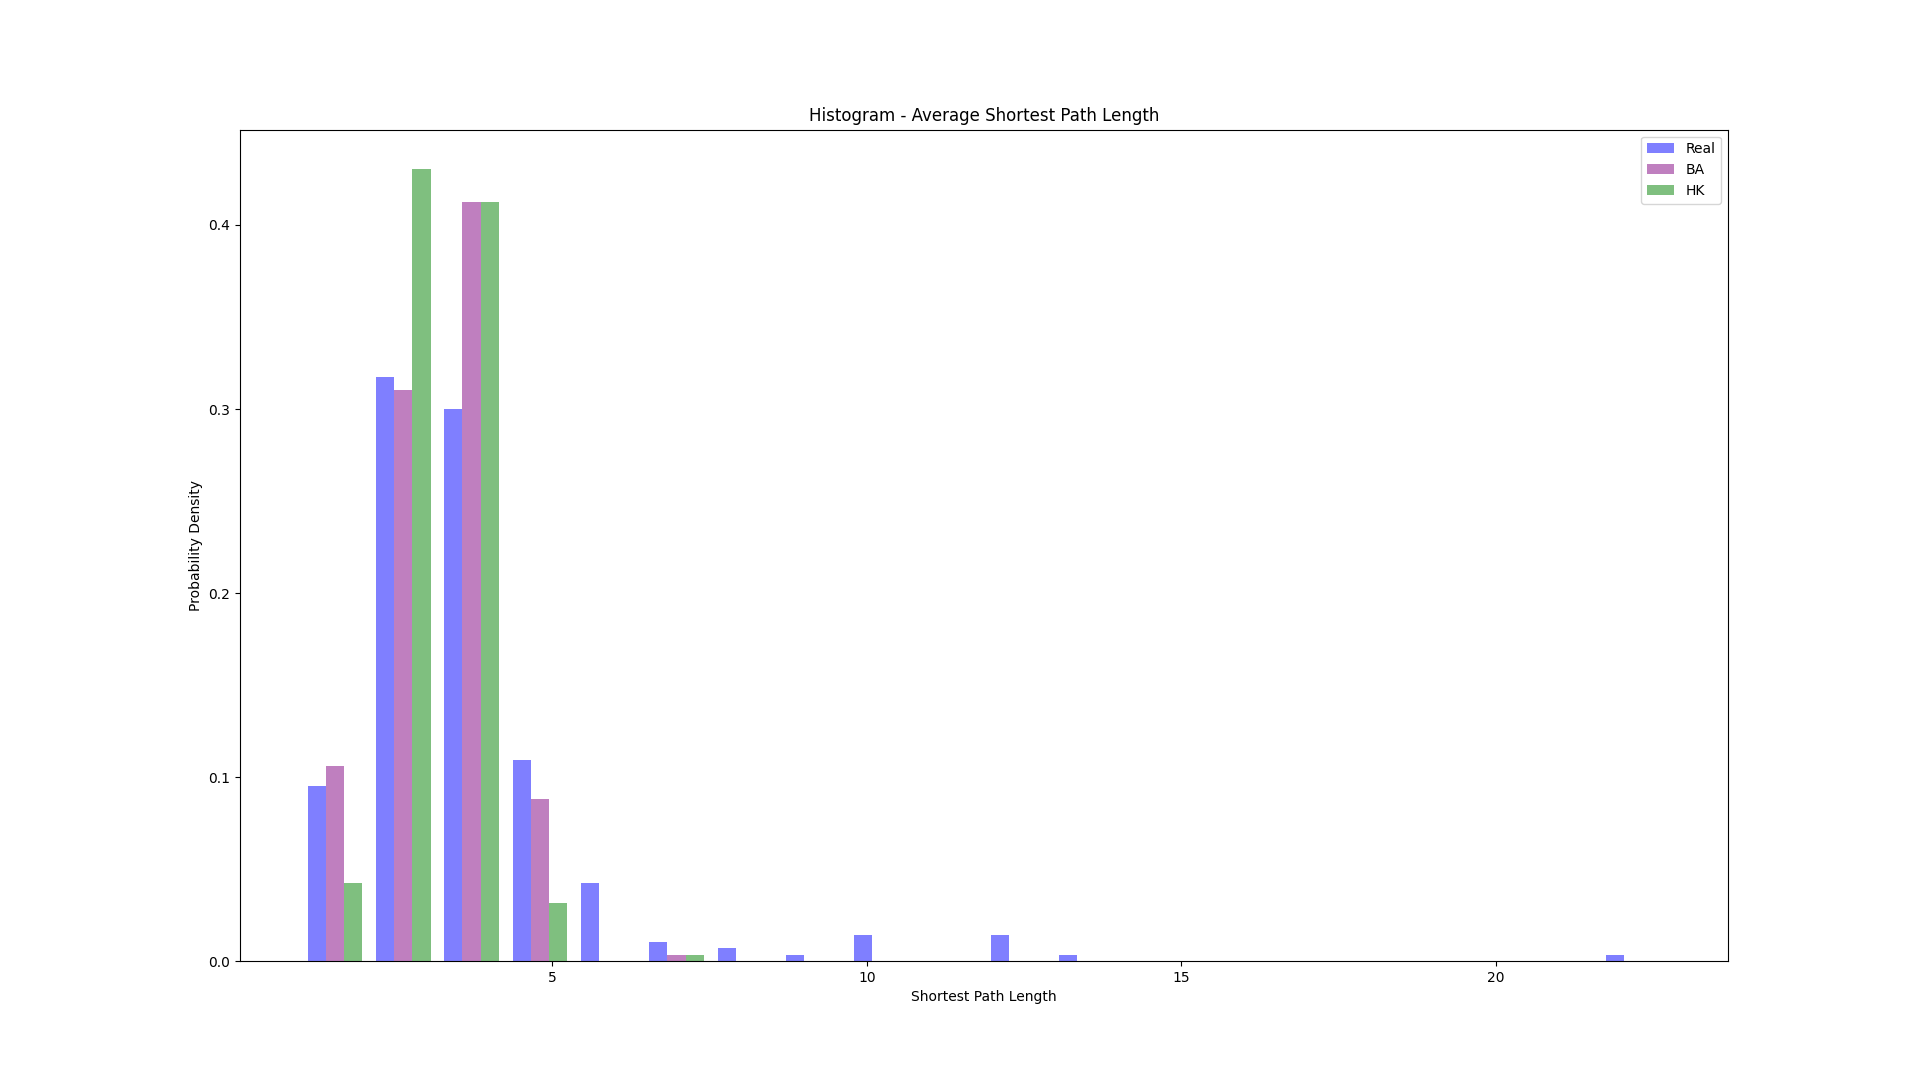

In [90]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Average Shortest Path Length")}.png"
display(Image(filename=img_path))

7. CDF - Average Clustering Coefficient

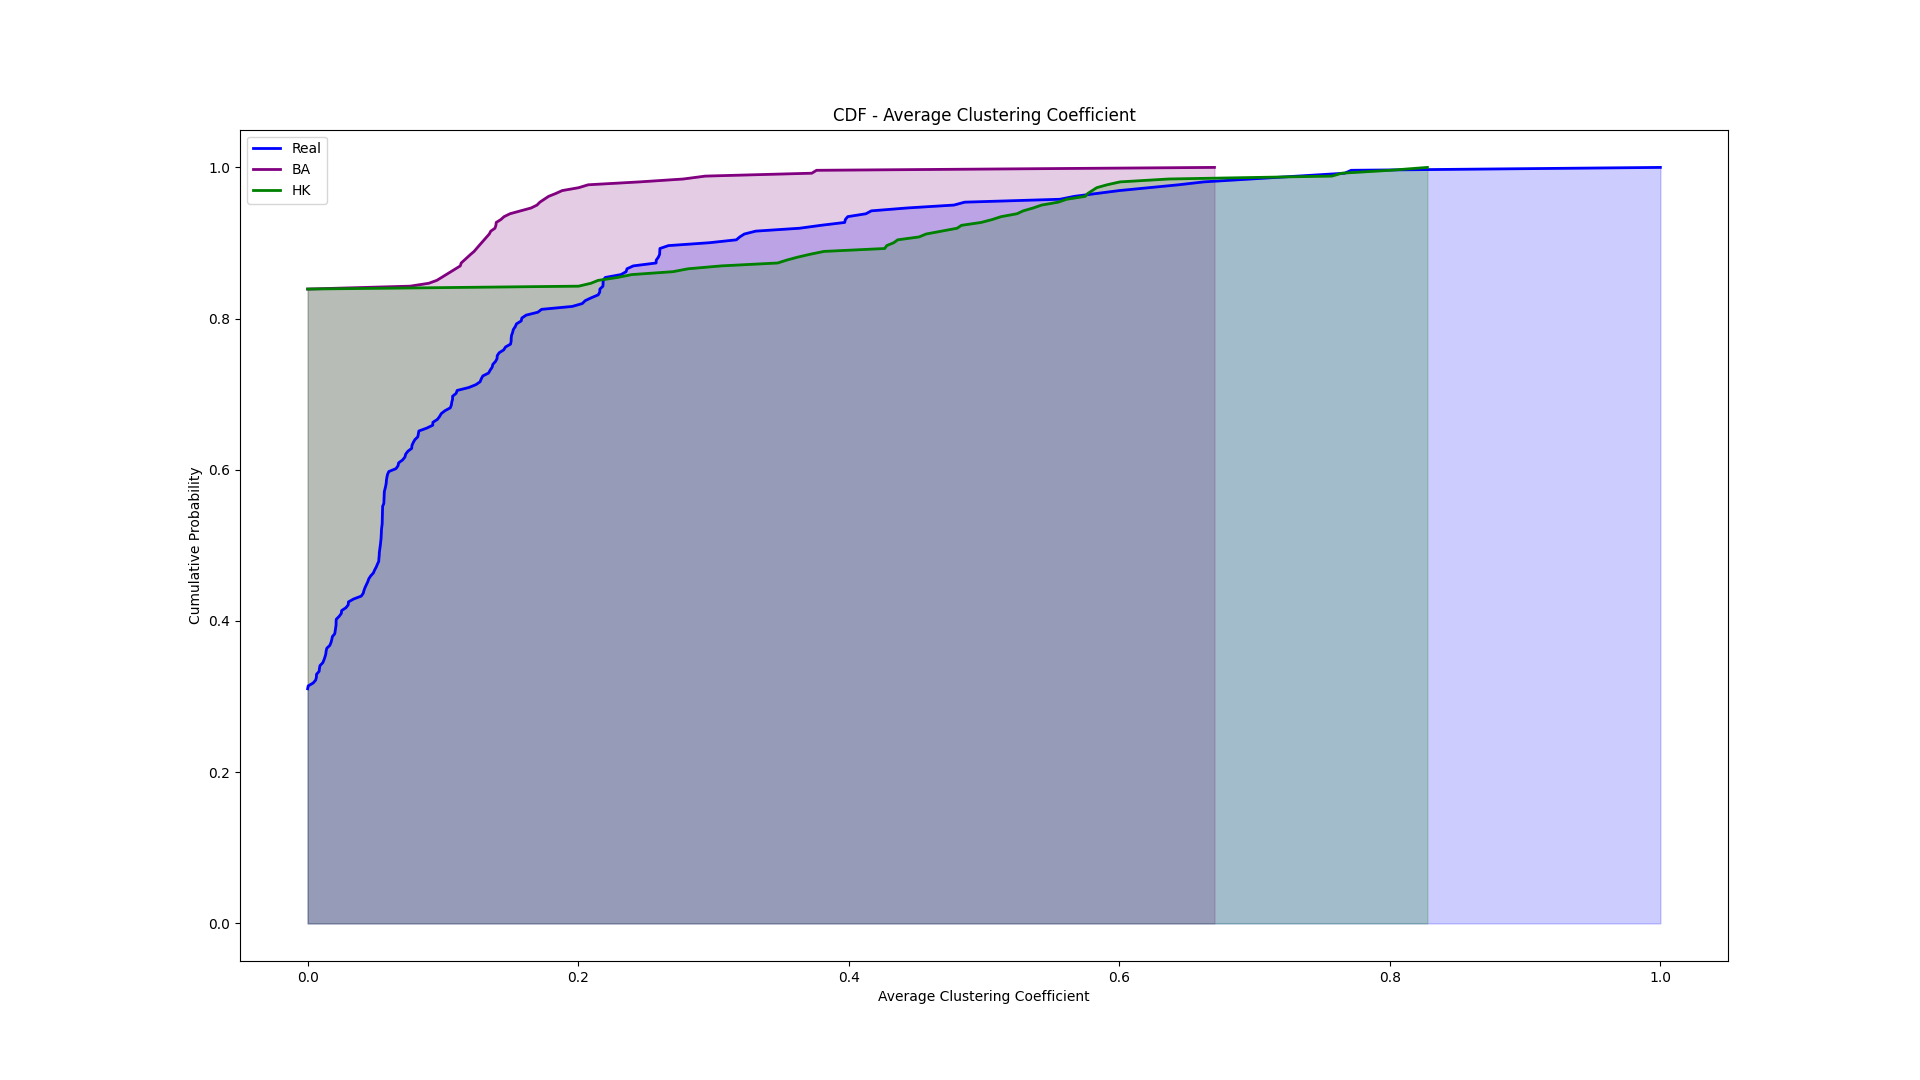

In [91]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "CDF - Average Clustering Coefficient")}.png"
display(Image(filename=img_path))

8. Histogram - Average Clustering Coefficient

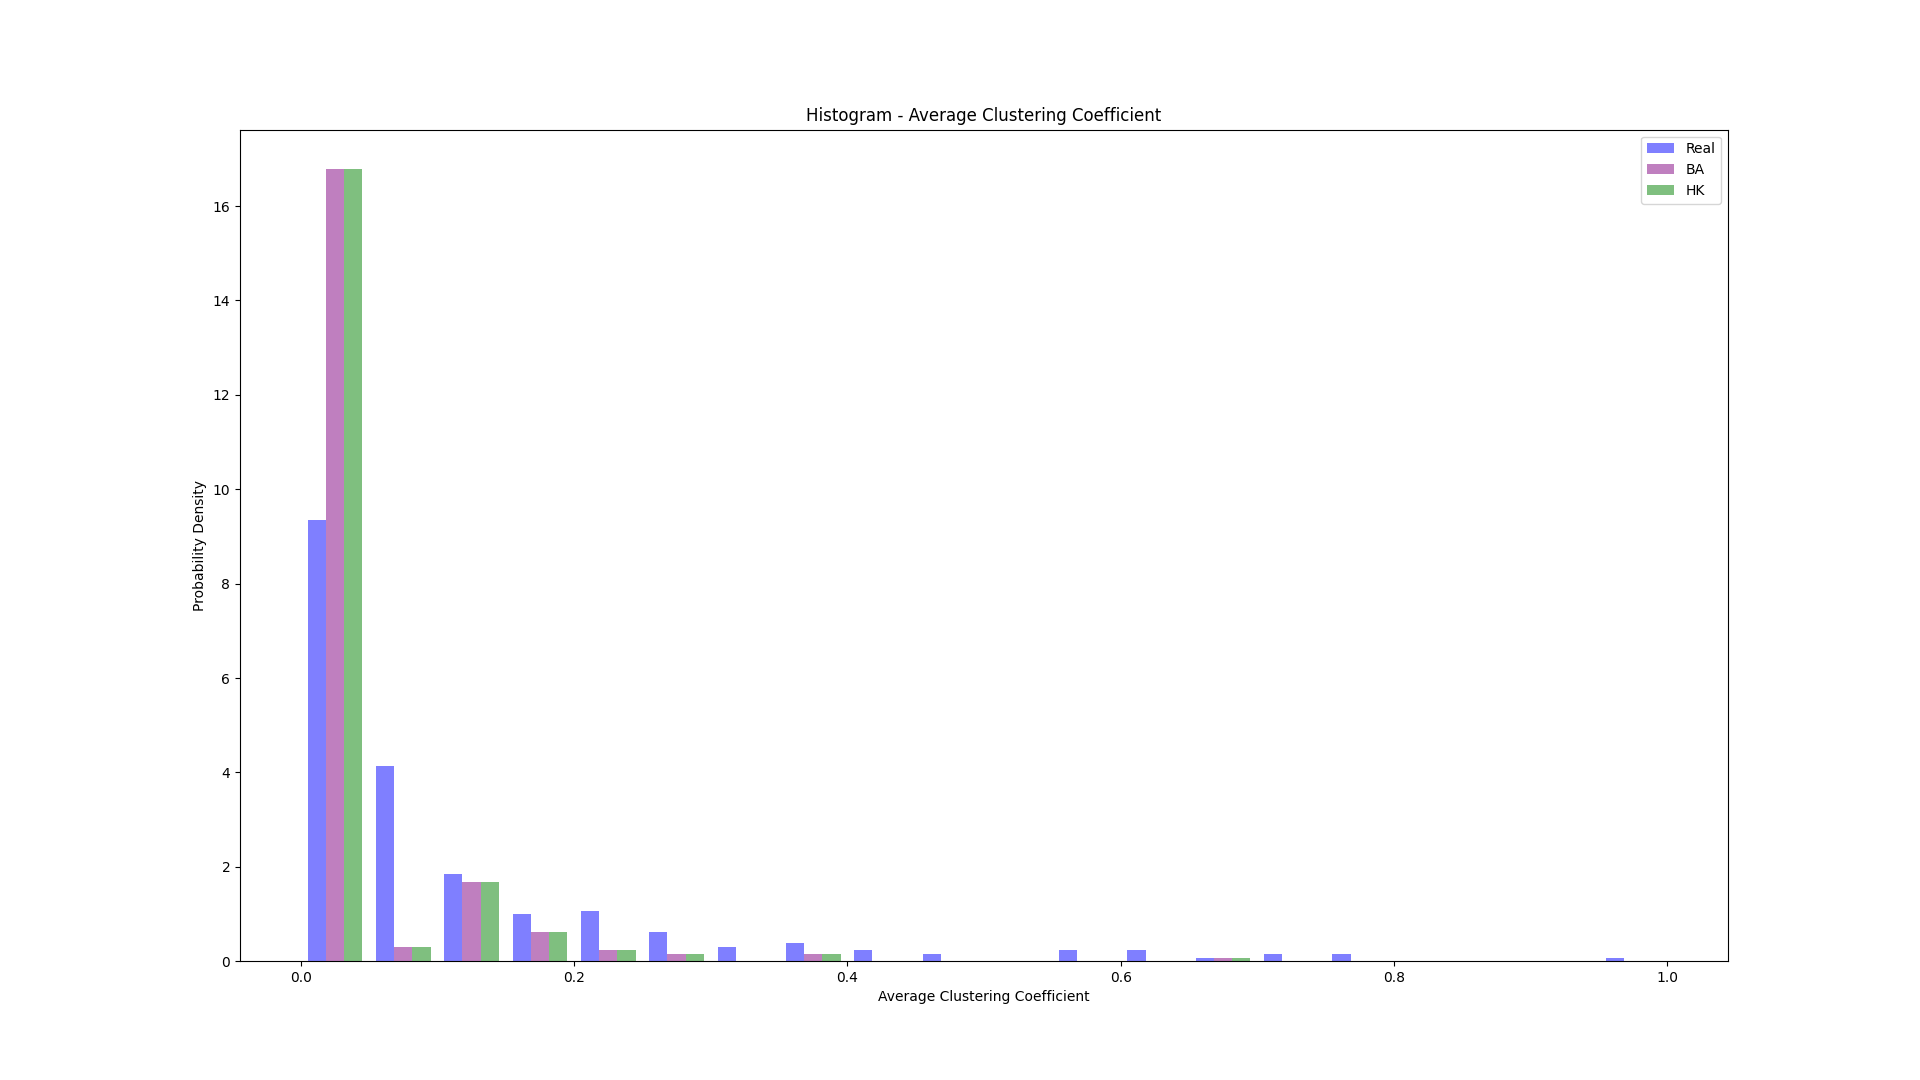

In [92]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "Histogram - Average Clustering Coefficient")}.png"
display(Image(filename=img_path))

9. Network Metrics Comparison.png (Heatmap)

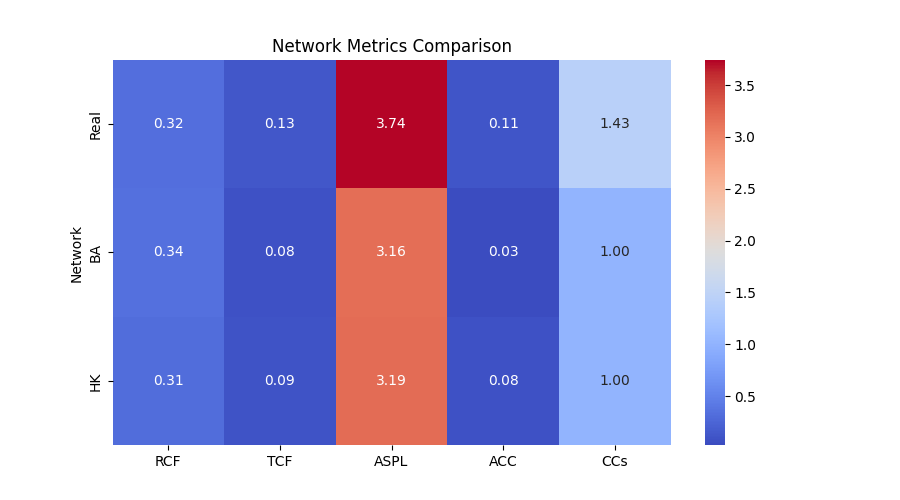

In [93]:
img_path = f"{os.path.join(FIGURES_VISUAL_PATH, "Network Metrics Comparison")}.png"
display(Image(filename=img_path))